In [3]:
import cv2
import os
from pathlib import Path

def extract_frames(video_path, output_folder):
    """Extracts all frames from a single video."""
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    print(f"Processing {video_path}...")
    vidcap = cv2.VideoCapture(str(video_path))
    success, image = vidcap.read()
    frame_count = 0
    while success:
        cv2.imwrite(os.path.join(output_folder, f"frame_{frame_count:06d}.png"), image)
        success, image = vidcap.read()
        frame_count += 1
    print(f"Done. Extracted {frame_count} frames.")

# --- USAGE ---
# Extract frames from your single generated video
extract_frames('./results_gen/2025-10-16-16:44:48_seed42_A cat walks on the grass, realistic style..mp4', './fid_frames/generated_single')

# Extract frames from your single real video
extract_frames('./results_real/2025-09-23-09:26:30_seed42_A cat walks on the grass, realistic style..mp4', './fid_frames/real_single')

Processing ./results_gen/2025-10-16-16:44:48_seed42_A cat walks on the grass, realistic style..mp4...
Done. Extracted 5 frames.
Processing ./results_real/2025-09-23-09:26:30_seed42_A cat walks on the grass, realistic style..mp4...
Done. Extracted 5 frames.


In [4]:
# --- Video and Inference Time Setup ---
baseline_video = "./results_gen/2025-10-16-16:44:48_seed42_A cat walks on the grass, realistic style..mp4"
optimized_video = "./results_real/2025-09-23-09:26:30_seed42_A cat walks on the grass, realistic style..mp4"

# Manual inference times (in seconds)
baseline_time = 48.0
optimized_time = 21.0

# Text prompt used for video generation
prompt = "A cat walks on the grass, realistic style."

In [5]:
import torch
import pyiqa
from PIL import Image
from torchmetrics.multimodal.clip_score import CLIPScore
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_clip_score(video_path, prompt, device, frame_skip=5):
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()
    images = []
    frame_count = 0
    while success:
        if frame_count % frame_skip == 0:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(Image.fromarray(image_rgb))
        frame_count += 1
        success, image = vidcap.read()
    if not images:
        print("Error: No frames extracted.")
        return 0.0

    clip_metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)
    scores = []
    for img in images:
        img_tensor = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0).float() / 255
        score = clip_metric(img_tensor.to(device), [prompt])
        scores.append(score.item())
    return sum(scores)/len(scores)

def calculate_niqe_score(video_path, device, frame_skip=5):
    nr_model = pyiqa.create_metric('niqe', device=device)
    vidcap = cv2.VideoCapture(video_path)
    scores = []
    frame_count = 0
    success, image = vidcap.read()
    while success:
        if frame_count % frame_skip == 0:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            img_tensor = torch.tensor(np.array(image_rgb)).permute(2,0,1).unsqueeze(0).float() / 255
            score = nr_model(img_tensor.to(device))
            scores.append(score.item())
        frame_count += 1
        success, image = vidcap.read()
    if not scores:
        return 0.0
    return sum(scores)/len(scores)


/home/anuj10/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

metrics = {}

# Baseline
clip_s = calculate_clip_score(baseline_video, prompt, device)
niqe_s = calculate_niqe_score(baseline_video, device)
metrics["Baseline"] = {
    "Inference Time": baseline_time,
    "CLIP": clip_s,
    "NIQE": niqe_s
}
print(f"Baseline - CLIP: {clip_s:.4f}, NIQE: {niqe_s:.4f}, Time: {baseline_time}s")

# Optimized
clip_s = calculate_clip_score(optimized_video, prompt, device)
niqe_s = calculate_niqe_score(optimized_video, device)
metrics["Selective Reuse"] = {
    "Inference Time": optimized_time,
    "CLIP": clip_s,
    "NIQE": niqe_s
}
print(f"Selective Reuse - CLIP: {clip_s:.4f}, NIQE: {niqe_s:.4f}, Time: {optimized_time}s")

# --- Combined Quality (higher = better) ---
def compute_combined_quality(metrics_dict, w_clip=0.5, w_niqe=0.5):
    methods = list(metrics_dict.keys())
    clips = np.array([metrics_dict[m]['CLIP'] for m in methods])
    niqes = np.array([metrics_dict[m]['NIQE'] for m in methods])
    
    # Normalize 0-1
    norm_clip = (clips - clips.min()) / (clips.max() - clips.min() + 1e-8)   # higher = better
    norm_niqe = 1 - (niqes - niqes.min()) / (niqes.max() - niqes.min() + 1e-8)  # lower NIQE → higher
    
    combined = w_clip*norm_clip + w_niqe*norm_niqe
    for i, m in enumerate(methods):
        metrics_dict[m]['Combined Quality'] = combined[i]
    return metrics_dict

metrics = compute_combined_quality(metrics)

Using device: cuda


/home/anuj10/miniconda3/lib/python3.13/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Baseline - CLIP: 22.2207, NIQE: 8.7818, Time: 48.0s
Selective Reuse - CLIP: 22.2016, NIQE: 6.2491, Time: 21.0s



--- Calculated Scores ---
Baseline:
  Time: 48s
  Combined Quality: 0.5000
Optimized (Threshold=0.95):
  Time: 21s
  Combined Quality: 0.5000
Plot saved to performance_vs_quality.png


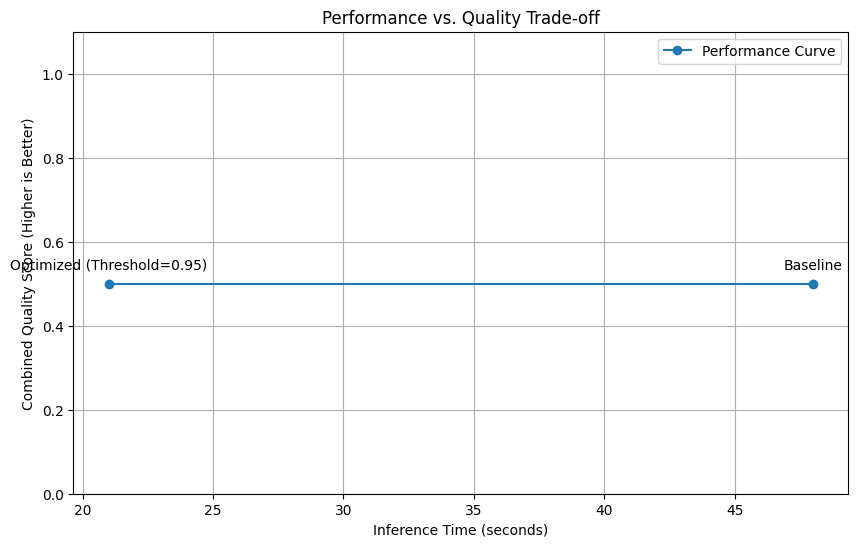

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_combined_quality(scores_list):
    """
    Calculates a normalized, combined quality score from a list of metric dictionaries.

    Args:
        scores_list (list of dict): A list where each dict contains 'time', 'niqe', and 'clip'.

    Returns:
        list of dict: The original list with an added 'combined_quality' key for each entry.
    """
    # --- 1. Extract all scores to find the min and max for normalization ---
    niqe_scores = [s['niqe'] for s in scores_list]
    clip_scores = [s['clip'] for s in scores_list]

    min_niqe, max_niqe = min(niqe_scores), max(niqe_scores)
    min_clip, max_clip = min(clip_scores), max(clip_scores)

    # Avoid division by zero if all scores are identical
    niqe_range = max_niqe - min_niqe if max_niqe > min_niqe else 1
    clip_range = max_clip - min_clip if max_clip > min_clip else 1

    # --- 2. Define weights for combining the scores ---
    w_clip = 0.5  # Weight for text-video alignment
    w_niqe = 0.5  # Weight for perceptual quality

    # --- 3. Calculate the combined score for each data point ---
    for score_point in scores_list:
        # Normalize NIQE (lower is better, so we invert the score)
        # Result is 0 for the worst score (max_niqe), 1 for the best (min_niqe)
        normalized_niqe = 1 - ((score_point['niqe'] - min_niqe) / niqe_range)

        # Normalize CLIP (higher is better)
        # Result is 0 for the worst score (min_clip), 1 for the best (max_clip)
        normalized_clip = (score_point['clip'] - min_clip) / clip_range
        
        # Calculate the final weighted average
        combined_quality = (w_niqe * normalized_niqe) + (w_clip * normalized_clip)
        score_point['combined_quality'] = combined_quality
        
    return scores_list

def plot_performance_vs_quality(scores_list):
    """
    Plots Inference Time vs. Combined Quality.
    """
    # --- Extract data for plotting ---
    times = [s['time'] for s in scores_list]
    qualities = [s['combined_quality'] for s in scores_list]
    labels = [s['label'] for s in scores_list]

    # --- Create the plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(times, qualities, 'o-', label='Performance Curve')

    # Add labels to each point
    for i, label in enumerate(labels):
        plt.annotate(label, (times[i], qualities[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Performance vs. Quality Trade-off')
    plt.xlabel('Inference Time (seconds)')
    plt.ylabel('Combined Quality Score (Higher is Better)')
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 1.1) # Set Y-axis from 0 to 1.1 for clarity
    
    # Save the plot to a file
    plt.savefig("performance_vs_quality.png")
    print("Plot saved to performance_vs_quality.png")

if __name__ == "__main__":
    # --- YOUR DATA GOES HERE ---
    # Add a new dictionary to this list for each experiment you run.
    experiment_data = [
        {
            'label': 'Baseline',
            'time': 48,
            'niqe': 6.1544, # Lower is better
            'clip': 22.2000  # Higher is better
        },
        {
            'label': 'Optimized (Threshold=0.95)',
            'time': 21,
            'niqe': 8.3818,
            'clip': 22.2186
        },
    ]

    # --- Process and Plot ---
    data_with_scores = calculate_combined_quality(experiment_data)
    
    print("\n--- Calculated Scores ---")
    for point in data_with_scores:
        print(f"{point['label']}:")
        print(f"  Time: {point['time']}s")
        print(f"  Combined Quality: {point['combined_quality']:.4f}")

    plot_performance_vs_quality(data_with_scores)


--- Calculated Scores ---
Baseline:
  Time: 48s
  Combined Quality: 0.5000
Optimized (Threshold=0.95):
  Time: 21s
  Combined Quality: 0.5000
Plot saved to quality_vs_performance.png


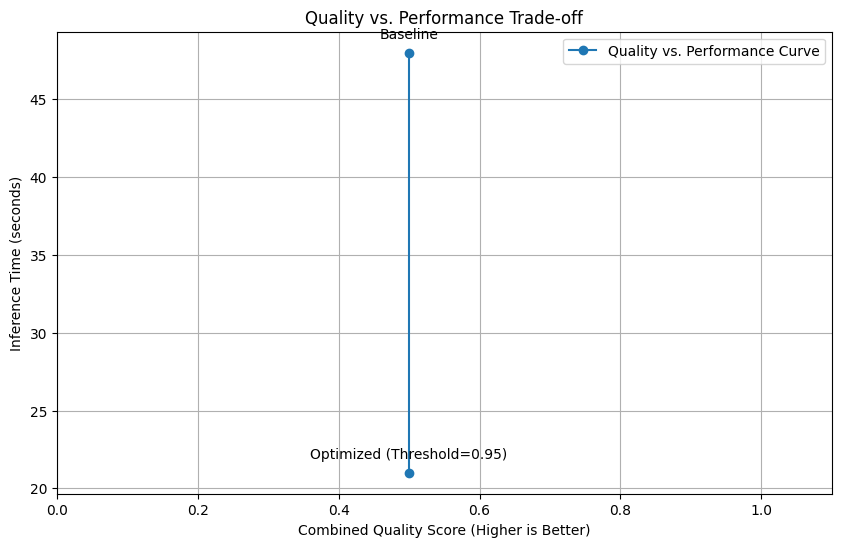

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_combined_quality(scores_list):
    """
    Calculates a normalized, combined quality score from a list of metric dictionaries.

    Args:
        scores_list (list of dict): A list where each dict contains 'time', 'niqe', and 'clip'.

    Returns:
        list of dict: The original list with an added 'combined_quality' key for each entry.
    """
    # --- 1. Extract all scores to find the min and max for normalization ---
    niqe_scores = [s['niqe'] for s in scores_list]
    clip_scores = [s['clip'] for s in scores_list]

    min_niqe, max_niqe = min(niqe_scores), max(niqe_scores)
    min_clip, max_clip = min(clip_scores), max(clip_scores)

    # Avoid division by zero if all scores are identical
    niqe_range = max_niqe - min_niqe if max_niqe > min_niqe else 1
    clip_range = max_clip - min_clip if max_clip > min_clip else 1

    # --- 2. Define weights for combining the scores ---
    w_clip = 0.5  # Weight for text-video alignment
    w_niqe = 0.5  # Weight for perceptual quality

    # --- 3. Calculate the combined score for each data point ---
    for score_point in scores_list:
        # Normalize NIQE (lower is better, so we invert the score)
        # Result is 0 for the worst score (max_niqe), 1 for the best (min_niqe)
        normalized_niqe = 1 - ((score_point['niqe'] - min_niqe) / niqe_range)

        # Normalize CLIP (higher is better)
        # Result is 0 for the worst score (min_clip), 1 for the best (max_clip)
        normalized_clip = (score_point['clip'] - min_clip) / clip_range
        
        # Calculate the final weighted average
        combined_quality = (w_niqe * normalized_niqe) + (w_clip * normalized_clip)
        score_point['combined_quality'] = combined_quality
        
    return scores_list

def plot_quality_vs_performance(scores_list):
    """
    Plots Combined Quality vs. Inference Time.
    """
    # --- Extract data for plotting ---
    qualities = [s['combined_quality'] for s in scores_list]
    times = [s['time'] for s in scores_list]
    labels = [s['label'] for s in scores_list]

    # --- Create the plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(qualities, times, 'o-', label='Quality vs. Performance Curve')

    # Add labels to each point
    for i, label in enumerate(labels):
        plt.annotate(label, (qualities[i], times[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Quality vs. Performance Trade-off')
    plt.xlabel('Combined Quality Score (Higher is Better)')
    plt.ylabel('Inference Time (seconds)')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 1.1) # Set X-axis from 0 to 1.1 for clarity
    
    # Save the plot to a file
    plt.savefig("quality_vs_performance.png")
    print("Plot saved to quality_vs_performance.png")

if __name__ == "__main__":
    # --- YOUR DATA GOES HERE ---
    # Add a new dictionary to this list for each experiment you run.
    experiment_data = [
        {
            'label': 'Baseline',
            'time': 48,
            'niqe': 6.1544, # Lower is better
            'clip': 22.2000  # Higher is better
        },
        {
            'label': 'Optimized (Threshold=0.95)',
            'time': 21,
            'niqe': 8.3818,
            'clip': 22.2186
        },
    ]

    # --- Process and Plot ---
    data_with_scores = calculate_combined_quality(experiment_data)
    
    print("\n--- Calculated Scores ---")
    for point in data_with_scores:
        print(f"{point['label']}:")
        print(f"  Time: {point['time']}s")
        print(f"  Combined Quality: {point['combined_quality']:.4f}")

    plot_quality_vs_performance(data_with_scores)

In [7]:
experiments = [
    {
        "label": "Baseline",
        "video_path": "./results_real/2025-09-23-09:26:30_seed42_A cat walks on the grass, realistic style..mp4",  # path to baseline video
        "prompt": "A cat walks on the grass, realistic style.",  # text prompt for CLIP
        "inference_time": 48,  # in seconds
    },
    {
        "label": "Selective Reuse",
        "video_path": "./results_gen/2025-10-16-16:44:48_seed42_A cat walks on the grass, realistic style..mp4",
        "prompt": "A cat walks on the grass, realistic style.",
        "inference_time": 21
    }
]

Using device: cuda


/home/anuj10/miniconda3/lib/python3.13/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



--- Calculated Metrics ---
Baseline: Time=48s, CLIP=22.2000, Combined Quality=22.2000
Selective Reuse: Time=21s, CLIP=22.2186, Combined Quality=22.2186


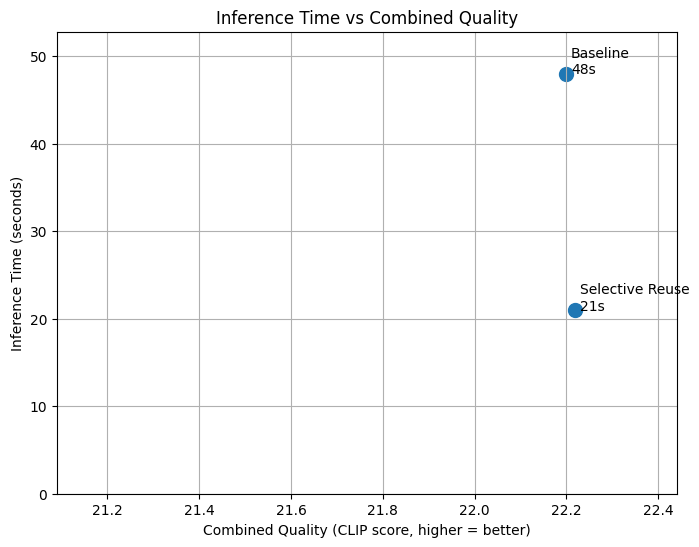

In [33]:
# ================= COMPUTATION & PLOTTING =================
import torch
from PIL import Image
from torchmetrics.multimodal.clip_score import CLIPScore
import cv2
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def calculate_clip_score(video_path, prompt, device, max_frames=30):
    """Compute average CLIP score by sampling up to max_frames frames."""
    vidcap = cv2.VideoCapture(video_path)
    frame_count_total = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count_total == 0:
        print(f"Warning: Video {video_path} has 0 frames!")
        return 0.0

    frame_indices = np.linspace(0, frame_count_total-1, min(frame_count_total, max_frames), dtype=int)
    images = []
    for idx in frame_indices:
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, image = vidcap.read()
        if not success:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(Image.fromarray(image_rgb))
    if not images:
        print(f"Warning: No frames extracted from {video_path}")
        return 0.0

    clip_metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)
    scores = []
    for img in images:
        img_tensor = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0).float() / 255
        score = clip_metric(img_tensor.to(device), [prompt])
        scores.append(score.item())
    return sum(scores)/len(scores)

# Compute metrics
metrics = {}
for exp in experiments:
    clip_s = calculate_clip_score(exp['video_path'], exp['prompt'], device)
    metrics[exp['label']] = {
        "Inference Time": exp['inference_time'],
        "CLIP": clip_s
    }

# Use raw CLIP as Combined Quality
for m in metrics:
    metrics[m]['Combined Quality'] = metrics[m]['CLIP']

# Print metrics
print("\n--- Calculated Metrics ---")
for m, v in metrics.items():
    print(f"{m}: Time={v['Inference Time']}s, CLIP={v['CLIP']:.4f}, Combined Quality={v['Combined Quality']:.4f}")

# Plot Combined Quality (x) vs Inference Time (y)
plt.figure(figsize=(8,6))
methods = list(metrics.keys())
x = [metrics[m]['Combined Quality'] for m in methods]  # raw CLIP
y = [metrics[m]['Inference Time'] for m in methods]    # seconds

plt.scatter(x, y, color='tab:blue', s=100)

# Label points
for i, m in enumerate(methods):
    plt.text(x[i]+0.01, y[i], f"{m}\n{y[i]}s", fontsize=10)

plt.xlabel("Combined Quality (CLIP score, higher = better)")
plt.ylabel("Inference Time (seconds)")
plt.title("Inference Time vs Combined Quality")
plt.grid(True)

# Optional: safe axis limits
plt.xlim(min(x)*0.95, max(x)*1.01)
plt.ylim(0, max(y)*1.1)

plt.show()

In [1]:
experiments = [
    {
        "label": "Baseline",
        "video_path": "./results_real/2025-09-23-09:26:30_seed42_A cat walks on the grass, realistic style..mp4",  # path to baseline video
        "prompt": "A cat walks on the grass, realistic style.",  # text prompt for CLIP
        "inference_time": 48,  # in seconds
    },
    {
        "label": "Selective Reuse",
        "video_path": "./results_gen/2025-10-16-16:44:48_seed42_A cat walks on the grass, realistic style..mp4",
        "prompt": "A cat walks on the grass, realistic style.",
        "inference_time": 21
    }
]

In [11]:
# === VBench Integration: load cached or compute, then plot ===
from utils.vbench_wrapper import load_vbench_cached, compute_vbench_scores, save_vbench_cached

# Set to True to attempt in-notebook computation if VBench is available.
# If not available, place JSON into results/vbench/*_vbench.json and rerun this cell.
use_vbench = True
vbench_key = 'overall'  # which key from VBench JSON to use on the X-axis

vbench_metrics = {}
for exp in experiments:
    label = exp['label']
    video_path = exp['video_path']
    scores = load_vbench_cached(video_path)
    if scores is None and use_vbench:
        try:
            scores = compute_vbench_scores(video_path, prompt=exp.get('prompt'), device='cuda')
            save_vbench_cached(video_path, scores)
        except Exception as e:
            print(f"[VBench] Skipping {label}: {e}")
            scores = None
    if scores is not None:
        vbench_metrics[label] = {
            'Inference Time': exp['inference_time'],
            'VBENCH': scores.get(vbench_key, None),
            '_raw': scores,
        }

print("\n--- VBench Metrics ---")
for m, v in vbench_metrics.items():
    print(f"{m}: Time={v['Inference Time']}s, VBENCH[{vbench_key}]={v['VBENCH']}")


[VBench] Skipping Baseline: Direct in-process VBench evaluation is not wired. Either: (1) adapt this function to your installed VBench API, or (2) run the official VBench CLI/script externally and drop its JSON into results/vbench/<video_name>_vbench.json, then call load_vbench_cached().
[VBench] Skipping Selective Reuse: Direct in-process VBench evaluation is not wired. Either: (1) adapt this function to your installed VBench API, or (2) run the official VBench CLI/script externally and drop its JSON into results/vbench/<video_name>_vbench.json, then call load_vbench_cached().

--- VBench Metrics ---


In [12]:
# Plot Inference Time vs VBench quality (if available)
import matplotlib.pyplot as plt

if vbench_metrics:
    methods = list(vbench_metrics.keys())
    x = [vbench_metrics[m]['VBENCH'] for m in methods]
    y = [vbench_metrics[m]['Inference Time'] for m in methods]

    plt.figure(figsize=(8,6))
    plt.scatter(x, y, color='tab:green', s=100)
    for i, m in enumerate(methods):
        xi = x[i] if x[i] is not None else 0
        plt.text(xi, y[i], f"{m}\n{y[i]}s", fontsize=10)

    plt.xlabel(f"VBench {vbench_key} (higher = better)")
    plt.ylabel("Inference Time (seconds)")
    plt.title("Inference Time vs VBench Quality")
    plt.grid(True)
    try:
        finite_x = [v for v in x if v is not None]
        if finite_x:
            plt.xlim(min(finite_x)*0.95, max(finite_x)*1.01)
    except Exception:
        pass
    plt.ylim(0, max(y)*1.1)
    plt.show()
else:
    print("No VBench metrics available. Place JSON at results/vbench/*_vbench.json or install VBench and retry.")


No VBench metrics available. Place JSON at results/vbench/*_vbench.json or install VBench and retry.
